# Bayesian Hierarchical Models

In [67]:
import numpy as np
import pandas as pd
from scipy import stats
from IPython.display import YouTubeVideo
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

We've seen so far that a Bayesian approach can be useful in cases where we have prior domain knowledge that we want to incorporate into our model. We've also seen that the effect of choosing a prior depends heavily on how much data we have: the less data we have, the more our conclusions tilt toward the prior.

In many cases, we may not have as much external prior knowledge, and we want to rely on parts of the dataset that are larger to help offset parts of the dataset that are smaller. We'll make this (very) abstract idea concrete with an example looking at kidney cancer deaths in the US between 1980 and 1989. The data used in this section, as well as inspiration for the modeling and analysis, comes from [Bayesian Data Analysis](http://www.stat.columbia.edu/~gelman/book/) pp 47-51. The cleaned version of the data came from [Robin Ryder](https://github.com/robinryder/BDA-kidney). Note that the dataset suffers from a severe bias: it only contains information on white men. We'll discuss issues with this later in this section.

We'll walk through the process of setting up a model for this more complex dataset, and in the process see several advantages and perspectives on Bayesian models.

## Example: Understanding Kidney Cancer Death Risk

Before we can start modeling, we must first understand the data. We'll focus on the following columns:
* `state`: the US state
* `Location`: the county and state as a string
* `fips`, which provides the [FIPS code](https://en.wikipedia.org/wiki/Federal_Information_Processing_Standard_state_code) for each county: this is a standard identifier that can often be used to join datasets with county-level information.
* `dc` and `dc.2`: the number of kidney cancer deaths between 1980-1984 and 1985-1989, respectively
* `pop` and `pop.2`: the population between 1980-1984 and 1985-1989, respectively

In [6]:
kc_full = pd.read_csv('kidney_cancer_1980.csv', skiprows=4)
# There are many other interesting columns, but we'll focus on these:
kc = kc_full.loc[:, ['state', 'Location', 'dc', 'dc.2', 'pop', 'pop.2']]
kc.head()

,state,Location,dc,dc.2,pop,pop.2
0,ALABAMA,"Autauga County, Alabama",2,1,61921,64915
1,ALABAMA,"Baldwin County, Alabama",7,15,170945,195253
2,ALABAMA,"Barbour County, Alabama",0,1,33316,33987
3,ALABAMA,"Bibb County, Alabama",0,1,30152,31175
4,ALABAMA,"Blount County, Alabama",3,5,88342,91547


For simplicity, we'll focus our analysis on 1980-1984. Our goal will be to understand **in which counties people are at the highest risk of kidney cancer death**. This could help inform public health actions, or could reveal information about underlying carcinogens (e.g., proximity to chemical treatment plants, etc.) that should be investigated and remedied.

<Axes: xlabel='rate_naive', ylabel='Count'>

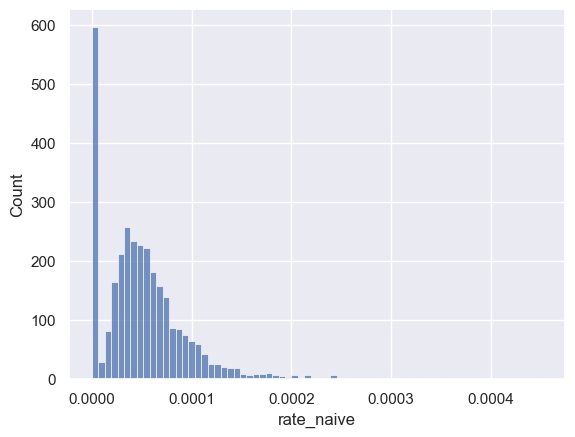

In [19]:
kc['rate_nopool'] = kc['dc'] / kc['pop']
sns.histplot(kc, x='rate_nopool')

From this, it appears that most counties have a rate between 1 in 100,000 ($0.00001$) and 1 in 10,000 ($0.0001$), but a sizeable number have a rate of 0.

If our goal is merely to characterize exactly what happened in each county from 1980-1984, this visualization could be enough. However, our goal is to understand the risk of kidney cancer death in each county, in a way that could help inform public health. This motivates the definition of our parameter of interest: **for county $i$, what is each person's average risk of dying from kidney cancer?** 

Intuitively, we can see that in counties with very low population, this dataset will provide a poor estimate of this parameter. Take, for example, a hypothetical county with only 10 people. Because the rate we're interested in is close to 1 in 10,000, we're very likely to see 0 deaths, but that doesn't mean that the risk for these 10 people is 0! We can see this empirically:

<Axes: xlabel='pop', ylabel='rate_naive'>

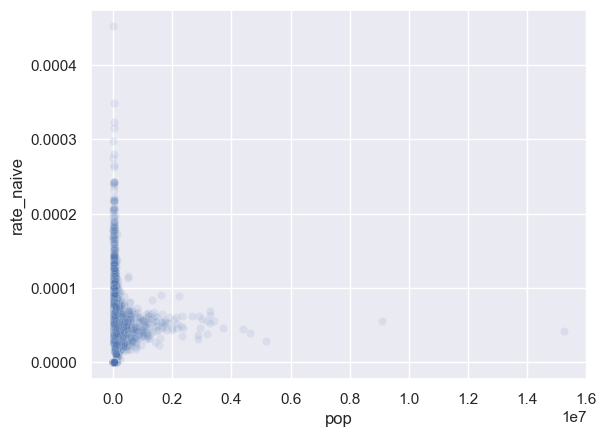

In [25]:
sns.scatterplot(kc, x='pop', y='rate_nopool', alpha=0.1);

For larger counties, our estimates are consistently between $0.00002$ and $0.00008$, but for the small counties, the estimates have much higher variability.

Here, we have a situation where we have a very large amount of data (in fact, our dataset contains a census of the entire population of interest), but we're trying to quantify a relatively rare phenomenon. Next, we'll see how Bayesian inference can help us leverage the more certain information from large counties to make good inferences for small counties.

## Bayesian Inference as a Middle Ground

We can consider the approach we took earlier as one extreme of a spectrum: we estimated the death rate for each county separately, and didn't pool or share any information across counties at all.

On the opposite extreme of the spectrum, we could pool all the data from all the counties together:

In [26]:
total_pop = kc['pop'].sum()
total_dc = kc['dc'].sum()
overall_rate = total_dc / total_pop
overall_rate

4.856485743364176e-05

While this provides a good estimate of the rate overall, it obscures variability across counties, and prevents us from making county-level inferences or finding locations most in need of targeting. 

To achieve a middle ground between these two extremes, we'll use a **Bayesian hierarchical model**:
* For each county, let $\theta_i \in [0, 1]$ be a random variable indicating the risk of kidney cancer death for an individual in that county. 
* We'll use the same prior distribution for each county: a Beta$(a, b)$ (for values of $a$ and $b$ yet to be determined), but each is a separate random variable and will have a separate posterior distribution.
* Let $y_i$ be a **binomial** random variable for each county indicating the number of kidney cancer deaths for that county, with parameters $n_i$ (the county population) and $\theta_i$ (the county-level risk).

Notationally, we can write the above bullet points as 

$$
\begin{align*}
\theta_i &\sim \mathrm{Beta}(a, b), & i \in \{1, 2, \ldots\} \\
y_i &\sim \mathrm{Binomial}(\theta_i, n_i), & i \in \{1, 2, \ldots, C\}
\end{align*}
$$

We saw in the last section that if the likelihood for a sequence of random variables $x_i$ is Bernoulli$(\theta)$ and the prior for $\theta$ is Beta$(a, b)$, then the posterior for $\theta$ is Beta$\left(a + \sum x_i, b + n - \sum x_i\right)$. We can also show that **if the likelihood a random variable $y$ is Binomial$(n, \theta)$ and the prior for $\theta$ is Beta$(a, b)$, then the posterior for $\theta$ is Beta$(a + y, b + n - y)$.** In other words, just as the Beta distribution is the conjugate prior for the Bernoulli likelihood, it is also the conjugate prior for the binomial likelihood. (It also happens to be the conjugate prior for the geometric likelihood as well!)

Putting all this together, we can now compute the posterior distribution. Instead of a single parameter $\theta$, we now have $C$ parameters, $\theta_1, \ldots, \theta_C$. The posterior distribution is the joint distribution of all of these random variables, conditioned on all of the observed data:

$$
\begin{align*}
p(\theta_1, \ldots, \theta_C | y_1, \ldots, y_C) 
    &\propto \overbrace{p(y_1, \ldots, y_c | \theta_1, \ldots, \theta_C)}^{\text{likelihood}}\,
             \overbrace{p(\theta_1, \ldots, \theta_C)}^{\text{prior}} \\
    &= \prod_{i=1}^C \theta_i^{a+y_i}(1-\theta_i)^{b + n_i - y_i}
\end{align*}
$$

From this, we can conclude that we can compute the posterior independently for every county: 

$$
\theta_i | y_i \sim \mathrm{Beta}(a + y_i, b + n_i - y_i)
$$

Note that according to the posterior distribution $p(\theta_1, \ldots, \theta_C | y_1, \ldots, y_C)$, the distribution for each county's parameter is independent of all other counties, because the joint distribution can be written as a product of the marginal distributions. But, they all share the parameters $a$ and $b$ in common.

Just as in the earlier example, we're now left with a critically important question: **how do we choose $a$ and $b$**? We'll examine four approaches, in increasing order of complexity and sophistication:

1. Uninformative prior
2. Educated guess
3. Empirical Bayes
4. Hierarchical model

#### Uninformative Prior

If we don't know anything about the data, we can choose an **uninformative prior**: in other words, one that provides as little information as possible. In this example, we might choose a uniform distribution over $[0, 1]$ (i.e., $a = b = 1$). While this avoids the problem of specifying a prior, it also isn't particularly useful. If we use such a weak prior, we're saying that risk values closer to $0.8$ are just as likely as values closer to $0.0001$: this clearly does not align with what we already know about the problem, and if we compute the posterior distributions, we'll see that the results won't be significantly different from the no-pooling estimates earlier.

#### Educated Guess

A good prior distribution should encode our knowledge about the quantity of interest. In this case, everything we know comes from what we've done here: above, we estimated an overall rate of about 4.9 in 10,000. If we choose $a = 5$ and $b = 9995$, then the mean of the prior is $5 \times 10^{-5}$. So, one possible option is Beta$(5, 9995)$.

Note that this is fairly arbitrary: we could have just as easily chosen $a = 10$ and $b = 19990$, or $a = 50$ and $b = 99950$, and obtained the same mean. 

#### Empirical Bayes

Empirical Bayes is a hybrid Bayesian-frequentist approach that uses frequentist methods to find guesses or prior distributions for quantities of interest. In this case, we'll use a frequentist approach to make a better guess for $a$ and $b$.

In particular, we saw earlier that the smaller counties produced naive estimates that varied too much. What if we just looked at the larger counties? We'll start by deciding on a (somewhat arbitrary) threshold of big versus small counties. From the scatterplot above, we can see that after a certain size, the non-pooled estimates seem to be much less variable. We can zoom in to decide on a threshold:

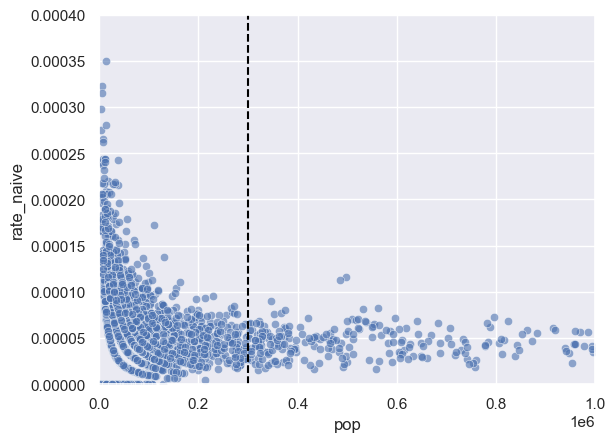

In [36]:
sns.scatterplot(kc, x='pop', y='rate_nopool', alpha=0.6);
plt.vlines(3e5, 0, 0.0004, color='black', ls='--')
plt.axis([0, 1e6, 0, 0.0004]);

Based on this, we'll use 300,000 as a cutoff (the dotted line), and ignore counties smaller than this when estimating the parameters of the prior:

<Axes: xlabel='rate_naive', ylabel='Count'>

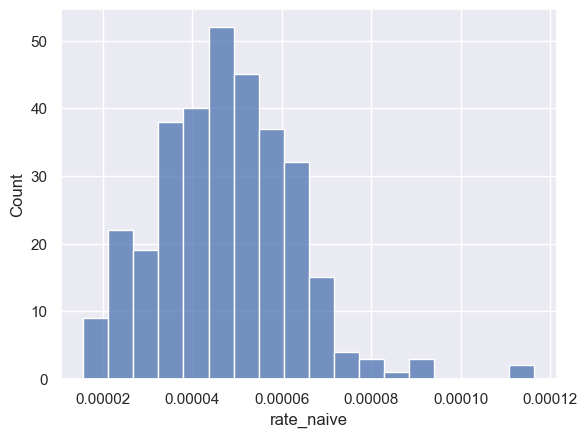

In [38]:
kc_large_counties = kc[kc['pop'] > 300000]
sns.histplot(kc_large_counties, x='rate_nopool')

We'll use this empirical distribution (or rather, a close approximation of it) as our prior: this is where the "empirical" in empirical Bayes comes from. Since we want to use a Beta prior, we need to fit a Beta distribution to this data. In other words, we need to find parameters $a$ and $b$ that are a good fit for this sequence of observations (in the histogram above). 

This is exactly the problem we solved in the last section using maximum likelihood! We'll use maximum likelihood to fit a Beta distribution to these data. This time, instead of deriving the MLEs for the Beta distribution, we'll use scipy to do it for us:

In [48]:
from scipy import stats
# The last two arguments tell scipy that it shouldn't try to shift or scale our Beta distribution
a_hat, b_hat, loc_, scale_ = stats.beta.fit(kc_large_counties['rate_nopool'], floc=0, fscale=1)
print(a_hat, b_hat)

9.270228244533358 195581.04114706165


Using this approach, our prior would be Beta$(9.27, 195581)$. To summarize what we did:

* We want to find the parameters $a$ and $b$ of the prior, using our data to help us since we don't have any domain knowledge
* We determined that we trust the data from the large counties, but not the smaller counties (because they are too variable). Note that this is an implicit **assumption** which could lead us astray: for example, if larger counties are biased toward lower or higher rates, then using them to estimate parameters of the prior is a bad idea.
* We looked at the naively estimated rates for the large counties only, and fit a Beta distribution to those, and then used that Beta distribution as our prior.

Let's compare the results for these two approaches. For ease of visualization, we'll look at a histogram of each county's LMSE estimate:

In [51]:
a_guess, b_guess = 5, 19995  # educated guess
a_eb, b_eb = a_hat, b_hat  # empirical bayes

def compute_posterior(kc, prior_a, prior_b):
    posterior_a = prior_a + kc['dc']
    posterior_b = prior_b + (kc['pop'] - kc['dc'])
    return posterior_a, posterior_b
kc['posterior_a_guess'], kc['posterior_b_guess'] = compute_posterior(kc, a_guess, b_guess)
kc['posterior_a_eb'], kc['posterior_b_eb'] = compute_posterior(kc, a_eb, b_eb)

# For a Beta(a, b) distribution, the mean is a / (a + b)
kc['lmse_guess'] = kc['posterior_a_guess'] / (kc['posterior_a_guess'] + kc['posterior_b_guess'])
kc['lmse_eb'] = kc['posterior_a_eb'] / (kc['posterior_a_eb'] + kc['posterior_b_eb'])


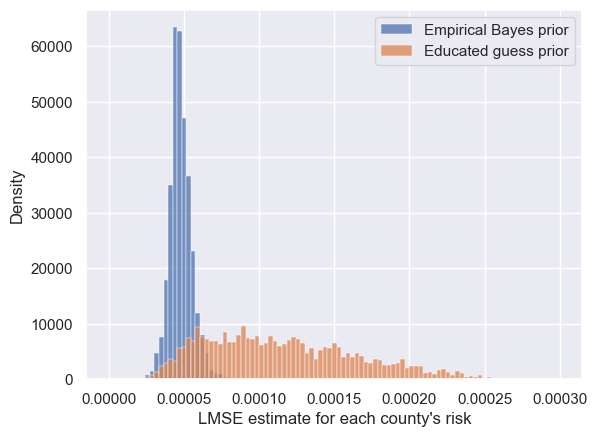

In [66]:
bins = np.linspace(0, 0.0003, 100)
sns.histplot(kc, x='lmse_eb', stat='density', label='Empirical Bayes prior', bins=bins)
sns.histplot(kc, x='lmse_guess',  stat='density', label='Educated guess prior', bins=np.linspace(0, 0.0003, 100))
plt.xlabel("LMSE estimate for each county's risk")
plt.legend()

In both cases, we no longer see estimates of 0. Note that because the empirical Bayes prior was stronger (i.e., less variable due to larger values of $a$ and $b$), the posterior estimates fall in a narrower range.

#### Full Hierarchical Model

Philosophically, taking a Bayesian approach means that we're deciding to treat unknown quantities as random variables, rather than fixed parameters. From what we've seen so far, in this model, $a$ and $b$ are important unknown quantities that have a fairly significant effect on the outcome of our inference. So, we'll now try treating them as random variables. Note that we now have two levels of unknown random variables: $\theta_i$, which we've already established, are the county-level risk probabilities. $a$ and $b$ are now US-level average parameters that reflect the risk across all counties. This is a common feature of hierarchical models: one set of variables is closely linked to the data for each group (in this case, county), and one set of variables represents more global information (in this case, the entire US).

But this leads to yet another modeling question: **what prior distribution do we choose for $a$ and $b$**?

Unfortunately, there is no convenient distribution that is a conjugate prior for the parameters of the Beta distribution. We'll use a uniform distribution, but we're still left with the question of how to choose the parameters of that uniform distribution. Since we know that $b >> a$, we'll make the somewhat arbitrary choice of saying $a \sim \mathrm{Uniform}(0, 50)$ and $b \sim \mathrm{Uniform}(0, 200000)$. We can then write out the full model:


$$
\begin{align*}
a &\sim \mathrm{Uniform}(0, 50) \\
b &\sim \mathrm{Uniform}(0, 300000) \\
\theta_i &\sim \mathrm{Beta}(a, b), & i \in \{1, 2, \ldots\} \\
y_i &\sim \mathrm{Binomial}(\theta_i, n_i), & i \in \{1, 2, \ldots\}
\end{align*}
$$

Unfortunately, there is no convenient way to compute the posterior distribution here: we must resort to approximate techniques. We'll return to this model in the next section, after we develop tools for approximate inference. In the remainder of this section, we'll explore different hierarchical models as well as a unifying framework for them known as graphical models.

#### Attempting to compute the posterior for the full hierarchical model

*Coming soon*

### Bias in the Kidney Cancer Dataset

*The content in this section is under active development and is subject to change.*

As mentioned earlier, the dataset as provided only contains data about white men. However, kidney cancer risk is not uniform, as seen in this data from the NIH's National Cancer Institute:

![explorer-graph.png](explorer-graph.png)

From this, we can see that there are clearly racial disparities in kidney cancer occurrence. Further, any county-level effects that we see may have racial disparities as well. How might we solve this? Unfortunately, in this case, because we don't have much insight into how the data were collected, and because they were collected so long ago, we can't improve our analysis.

## Example: Gaussian Mixture Model for Exoplanet Habitability

*Coming soon*

In [ ]:
YouTubeVideo('lCbn8UrJ8-U')

In [ ]:
YouTubeVideo('KaD7uJeK_JI')

In [ ]:
YouTubeVideo('e6CoEsLiMXc')